# Part 1

In [52]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import random

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import Lasso, Ridge, LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import accuracy_score, precision_score, make_scorer, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.metrics import geometric_mean_score
from sklearn.utils import resample

from IPython.display import clear_output

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
file = 'Intrusion_detection_NSL_KDD.csv'
data = pd.read_csv(file)

In [5]:
def K_fold_cross_validation(clf, X, y, cv=10):
    _scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='micro'),
        'recall': make_scorer(recall_score, average='micro'),
        'geometric_mean_score': make_scorer(geometric_mean_score, average='micro', greater_is_better=True),
        'f1': make_scorer(f1_score, average='micro'),
    }

    cross = cross_validate(
        estimator=clf, 
        X=X, 
        y=y, 
        cv=cv, 
        scoring=_scoring,
        return_train_score=False,
        n_jobs=-1
        )

    return cross


def K_fold_times(clf, X, y, cv=10, times=100):
    cross_val_res = []
    for i in range(times):
        clear_output(wait=True)
        print('Iteration: ', i+1)
        cross_val = K_fold_cross_validation(clf, X, y, cv)
        cross_val_res.append(cross_val)
        
    return cross_val_res

    

In [6]:
def post_process(KFold_result): 
    acc = []
    pre = []
    rec = []
    gmean = []
    f1 = []
    for data in KFold_result:
        acc = np.append(acc, data['test_accuracy'])
        pre = np.append(pre, data['test_precision'])
        rec = np.append(rec, data['test_recall'])
        gmean = np.append(gmean, data['test_geometric_mean_score'])
        f1 = np.append(f1, data['test_f1'])

    data = {
        'accuracy': [max(acc), acc.mean(), acc.std()], 
        'precision': [max(pre), pre.mean(), pre.std()], 
        'recall': [max(rec), rec.mean(), rec.std()], 
        'geo mean': [max(gmean), gmean.mean(), gmean.std()],
        'f1': [max(f1), f1.mean(), f1.std()],
    }

    df = pd.DataFrame(data, index=['best', 'mean', 'std'])

    return df

In [7]:
# Data type sorting

Attack_Class = {
    'dos': ['apache2', 'back', 'pod', 'processtable', 'worm', 'neptune', 'smurf', 'land', 'udpstorm', 'teardrop'],
    'probe': ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint'],
    'r2l' : ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named'],
    'u2r': ['buffer_overflow', 'xterm','sqlattack','perl', 'loadmodule', 'ps','rootkit'],
}

In [8]:
# Mapping types to new classes

data['attack_class'] = data['attack_type'].map(lambda x: 'dos' if x in Attack_Class['dos'] else 'probe' if x in Attack_Class['probe'] else 'r2l' if x in Attack_Class['r2l'] else 'u2r' if x in Attack_Class['u2r'] else 'normal')

In [9]:
# One hot encoding

if 'attack_type' in data.columns:   
    data = data.drop(['attack_type'], axis=1)

data_dummy = pd.get_dummies(data = data, columns = ['protocol_type', 'service', 'flag'])

In [10]:
data_normal = data_dummy.loc[data_dummy['attack_class'] == 'normal']
data_dos = data_dummy.loc[data_dummy['attack_class'] == 'dos']
data_probe = data_dummy.loc[data_dummy['attack_class'] == 'probe']
data_r2l = data_dummy.loc[data_dummy['attack_class'] == 'r2l']
data_u2r = data_dummy.loc[data_dummy['attack_class'] == 'u2r']

### Step 1 
A certain amount of sample data was taken from each data set. Empty lines in some data sets have been removed. 

In [11]:
# Original data count

target = {
    'normal': 6817,
    'dos': 11617,
    'probe': 988,
    'r2l': 53,
    'u2r': 3086,
}

In [12]:
# Select the number of samples to match with original data set

data_normal_keep = data_normal.iloc[random.randint(0, data_normal.shape[0], target['normal'])]

data_dos_keep = data_dos.iloc[random.randint(0, data_dos.shape[0], target['dos'])]

data_probe_keep = data_probe.iloc[random.randint(0, data_probe.shape[0], target['probe'])]

data_r2l_keep = data_r2l.iloc[random.randint(0, data_r2l.shape[0], target['r2l'])]

data_u2r_keep = data_u2r.iloc[random.randint(0, data_u2r.shape[0], target['u2r'])]


### Step 2
The data sets obtained are normalized with the min-max normalization.

In [13]:
# Scaling data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

combined_data = pd.concat([data_normal_keep, data_dos_keep, data_probe_keep, data_r2l_keep, data_u2r_keep])

X = scaler.fit_transform(combined_data.drop(['attack_class'], axis=1))
y = combined_data['attack_class']


### Step 3
The data sets are classified with SVM, KNN and DT machine learning methods

In [14]:
# SVM Classifier

svm_linearSVC_clf = svm.LinearSVC()
cv = KFold(n_splits=10, shuffle=True)
result_linearSVC = K_fold_times(svm_linearSVC_clf, X, y, cv=cv,times=100)
df_result_linearSVC = post_process(result_linearSVC)

Iteration:  100


In [15]:
svm_quad = svm.SVC(kernel='poly', degree=2)
cv = KFold(n_splits=10, shuffle=True)
result_svm_quad = K_fold_times(svm_quad, X, y, cv=cv, times=100)
df_result_svm_quad = post_process(result_svm_quad)

Iteration:  100


In [16]:
svm_cube = svm.SVC(kernel='poly', degree=3)
cv = KFold(n_splits=10, shuffle=True)
result_svm_cube = K_fold_times(svm_cube, X, y, cv = cv,times=100)
df_result_svm_cube = post_process(result_svm_cube)

Iteration:  100


In [17]:
knn_fine = KNeighborsClassifier(n_neighbors=1)
cv = KFold(n_splits=10, shuffle=True)
result_knn_fine = K_fold_times(knn_fine, X, y, cv = cv,times=100)
df_result_knn_fine = post_process(result_knn_fine)

Iteration:  100


In [18]:
knn_med = KNeighborsClassifier(n_neighbors=10)
cv = KFold(n_splits=10, shuffle=True)
result_knn_med = K_fold_times(knn_med, X, y, cv = cv,times=100)
df_result_knn_med = post_process(result_knn_med)

Iteration:  100


In [19]:
knn_cubic = KNeighborsClassifier(p=3, n_neighbors=10)
cv = KFold(n_splits=10, shuffle=True)
result_knn_cubic = K_fold_times(knn_cubic, X, y, cv = cv,times=100)
df_result_knn_cubic = post_process(result_knn_cubic)

Iteration:  100


In [20]:
tree_fine = DecisionTreeClassifier(max_depth = 7)
cv = KFold(n_splits=10, shuffle=True)
result_tree_fine = K_fold_times(tree_fine, X, y, cv = cv,times=100)
df_result_tree_fine = post_process(result_tree_fine)

Iteration:  100


In [21]:
tree_med = DecisionTreeClassifier(max_depth = 20)
cv = KFold(n_splits=10, shuffle=True)
result_tree_med = K_fold_times(tree_med, X, y, cv = cv,times=100)
df_result_tree_med = post_process(result_tree_med)

Iteration:  100


In [22]:
result = pd.concat([df_result_linearSVC, df_result_svm_quad, df_result_svm_cube, df_result_knn_fine, df_result_knn_med, df_result_knn_cubic, df_result_tree_fine, df_result_tree_med], axis=0)

In [23]:
models = np.append([], [
    ['SVM Linear']*3, 
    ['SVM Quadratic']*3, 
    ['SVM Cubic']*3, 
    ['KNN Fine']*3, 
    ['KNN Medium']*3, 
    ['KNN Cubic']*3, 
    ['Tree Fine']*3, 
    ['Tree Medium']*3
])

arr2 = ['best', 'mean', 'std'] * 8

tuples = list(zip(models, arr2))

index = pd.MultiIndex.from_tuples(tuples, names=['model', 'result'])

result.set_index(index, inplace=True)

In [24]:
result.to_latex('result.tex')
display(result)

/tmp/ipykernel_7860/2936992748.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  result.to_latex('result.tex')


accuracy  precision    recall  geo mean        f1
model         result                                                   
SVM Linear    best    0.981826   0.981826  0.981826  0.988618  0.981826
              mean    0.971675   0.971675  0.971675  0.982234  0.971675
              std     0.003544   0.003544  0.003544  0.002228  0.003544
SVM Quadratic best    0.978280   0.978280  0.978280  0.986391  0.978280
              mean    0.969557   0.969557  0.969557  0.980906  0.969557
              std     0.003411   0.003411  0.003411  0.002147  0.003411
SVM Cubic     best    0.982270   0.982270  0.982270  0.988896  0.982270
              mean    0.971948   0.971948  0.971948  0.982408  0.971948
              std     0.003395   0.003395  0.003395  0.002138  0.003395
KNN Fine      best    0.996897   0.996897  0.996897  0.998060  0.996897
              mean    0.992173   0.992173  0.992173  0.995104  0.992173
              std     0.001782   0.001782  0.001782  0.001116  0.001782
KNN Medium    best    0.992908   0.992908  0.992908  0.995564  0.992908
              mean    0.983041   0.983041  0.983041  0.989374  0.983041
              std     0.002766   0.002766  0.002766  0.001734  0.002766
KNN Cubic     best    0.994238   0.994238  0.994238  0.996396  0.994238
              mean    0.987720   0.987720  0.987720  0.992313  0.987720
              std     0.002246   0.002246  0.002246  0.001408  0.002246
Tree Fine     best    0.983156   0.983156  0.983156  0.989452  0.983156
              mean    0.966288   0.966288  0.966288  0.978844  0.966288
              std     0.003827   0.003827  0.003827  0.002406  0.003827
Tree Medium   best    0.998670   0.998670  0.998670  0.999169  0.998670
              mean    0.993561   0.993561  0.993561  0.995972  0.993561
              std     0.001847   0.001847  0.001847  0.001156  0.001847

In [25]:
their_result = pd.read_excel('Thier_Results.xlsx')
their_result.set_index(['model', 'result'], drop=True, inplace=True)

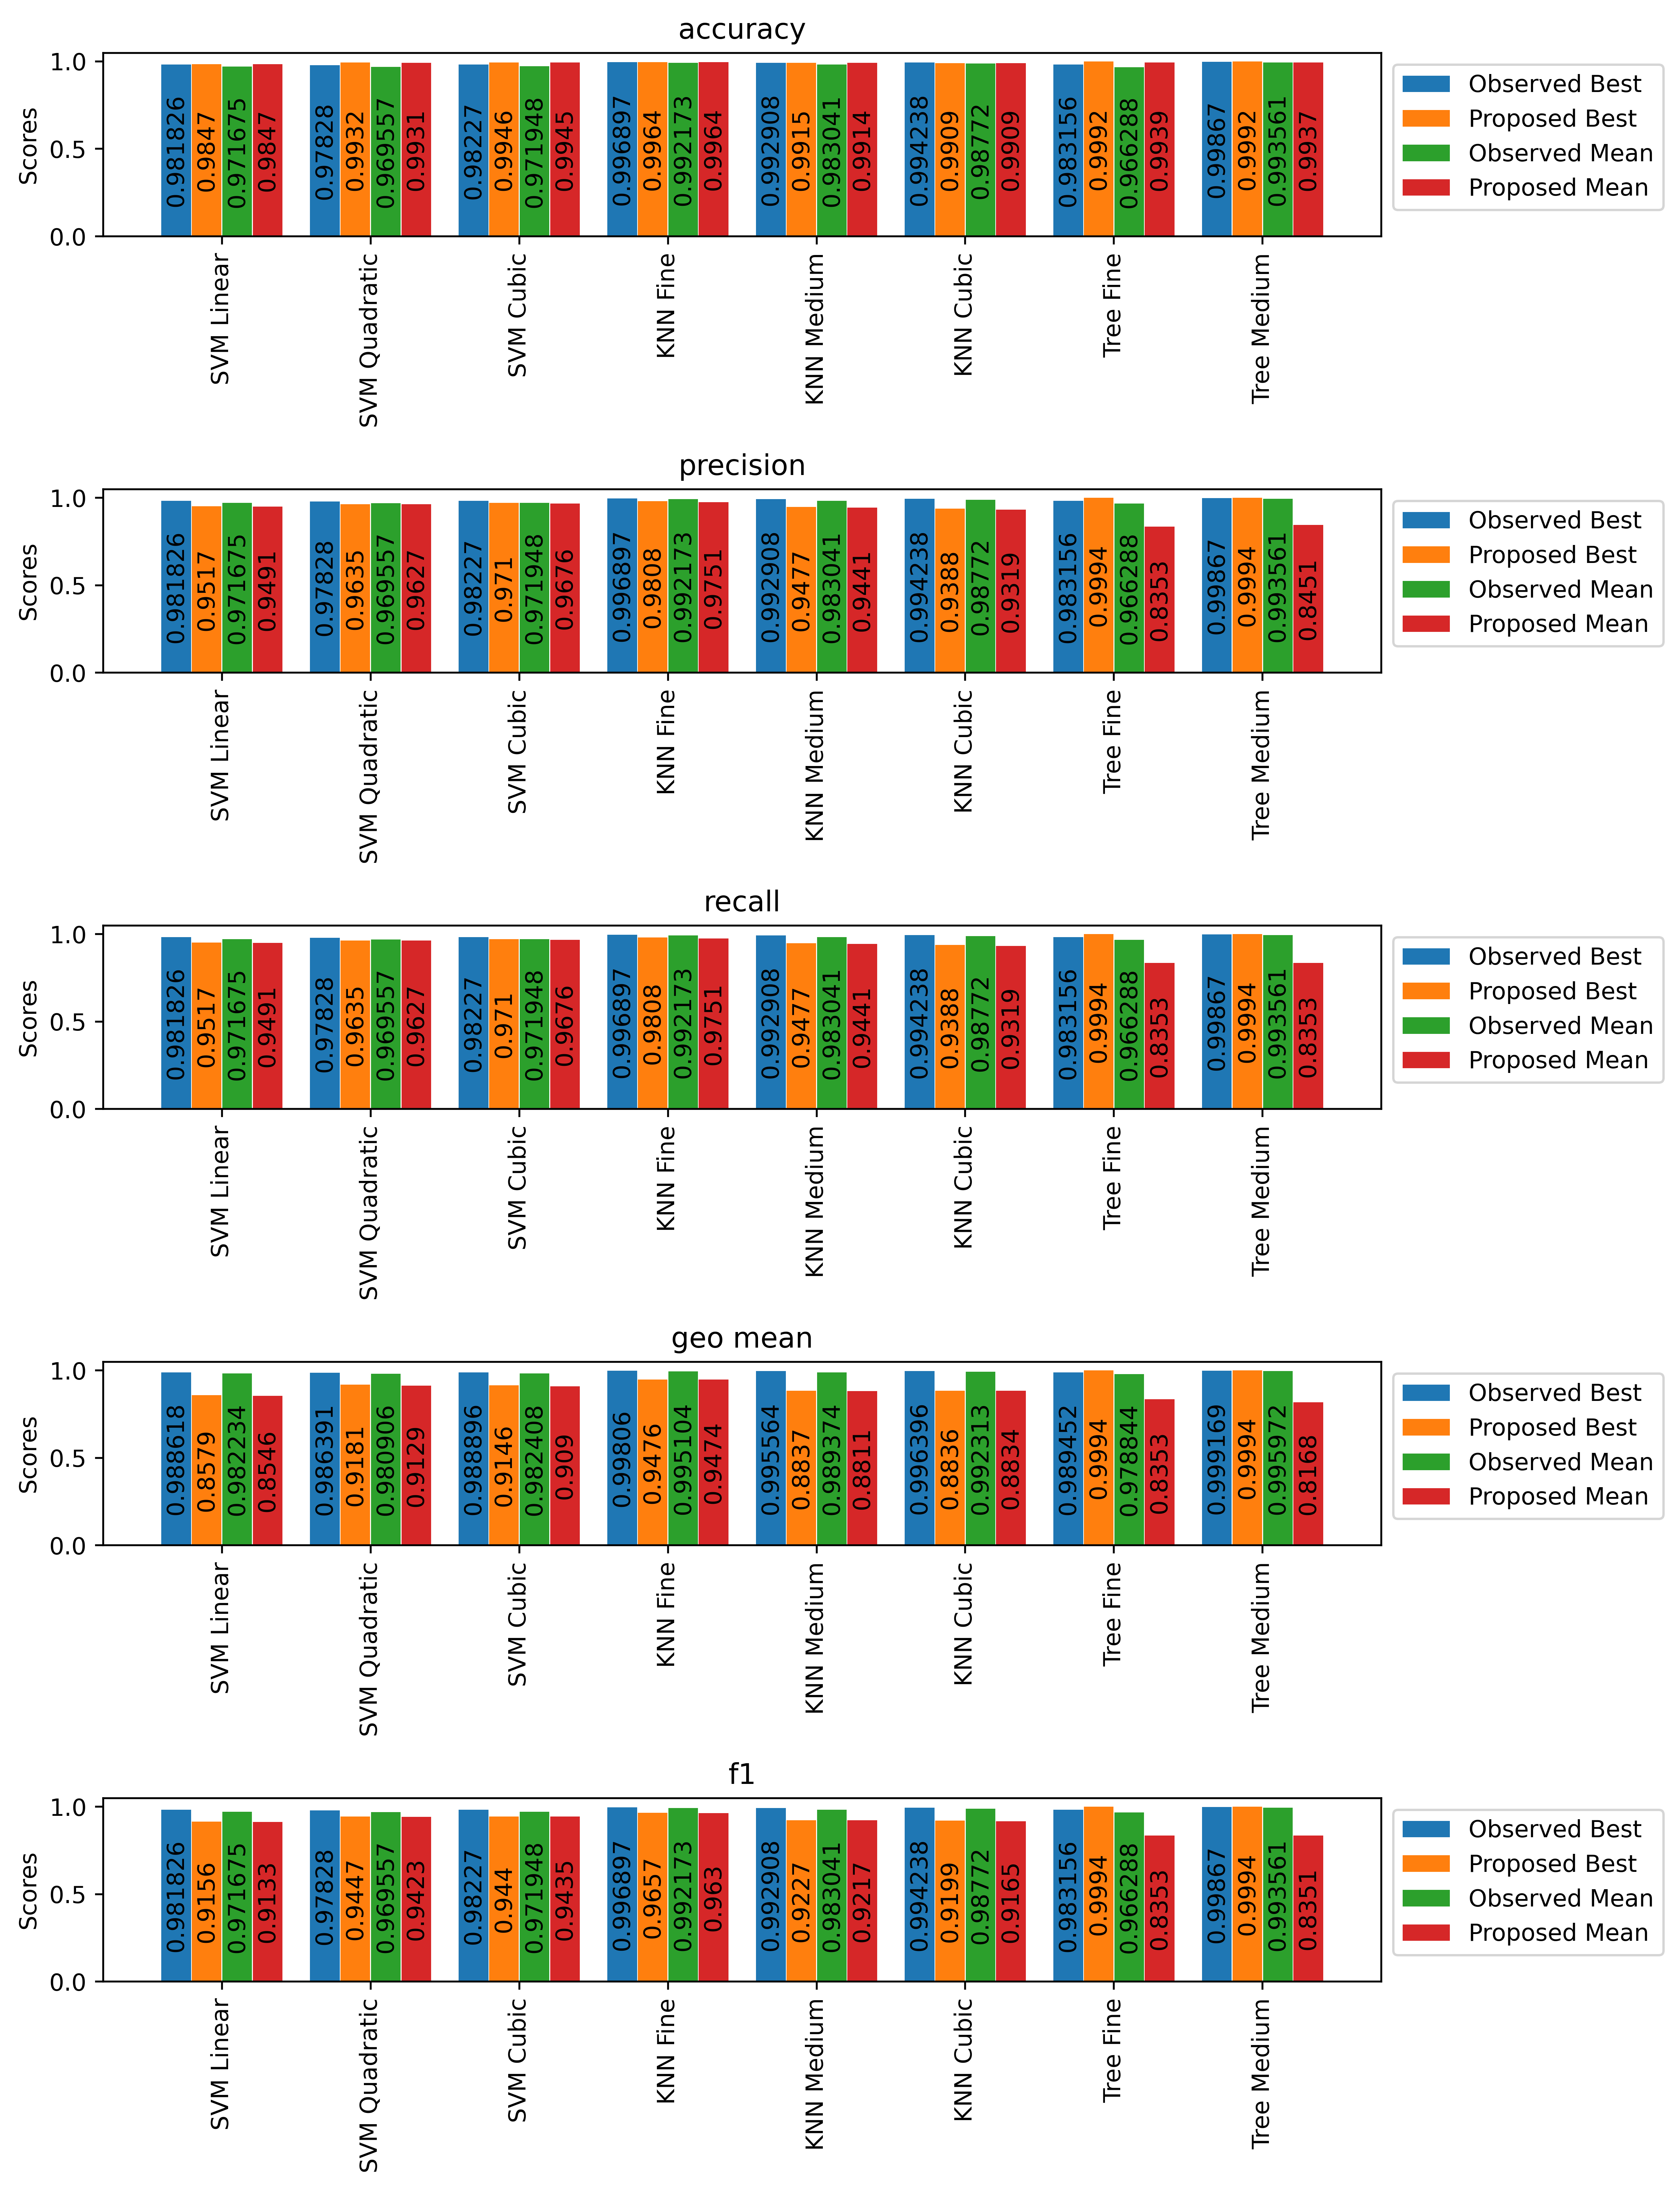

In [32]:
score_type = ['accuracy', 'precision', 'recall', 'geo mean', 'f1']

labels = ['SVM Linear', 'SVM Quadratic', 'SVM Cubic', 'KNN Fine', 
          'KNN Medium', 'KNN Cubic', 'Tree Fine', 'Tree Medium']




x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
gap = 0.65
pos = np.linspace(-width/gap, width/gap, 4)

fig, ax = plt.subplots(len(score_type), 1, figsize=(10, 13), dpi=500)

for i in range(len(score_type)):

    my_best = result.xs('best', axis=0, level=1, drop_level=False)[score_type[i]]
    their_best = their_result.xs('best', axis=0, level=1, drop_level=False)[score_type[i]]
    my_mean = result.xs('mean', axis=0, level=1, drop_level=False)[score_type[i]]
    their_mean = their_result.xs('mean', axis=0, level=1, drop_level=False)[score_type[i]]

    rects1 = ax[i].bar(x + pos[0], my_best, width, label=f'Observed Best')
    rects2 = ax[i].bar(x + pos[1], their_best, width, label='Proposed Best')
    rects3 = ax[i].bar(x + pos[2], my_mean, width, label='Observed Mean')
    rects4 = ax[i].bar(x + pos[3], their_mean, width, label='Proposed Mean')

    ax[i].bar_label(rects1, rotation = 90, label_type = 'center')
    ax[i].bar_label(rects2, rotation = 90, label_type = 'center')
    ax[i].bar_label(rects3, rotation = 90, label_type = 'center')
    ax[i].bar_label(rects4, rotation = 90, label_type = 'center')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[i].set_ylabel('Scores')
    ax[i].set_title(score_type[i])
    ax[i].set_xticks(x, labels, rotation = 90)

    ax[i].legend(loc = 'best',bbox_to_anchor=(1, 1))
    
fig.tight_layout()
plt.show()

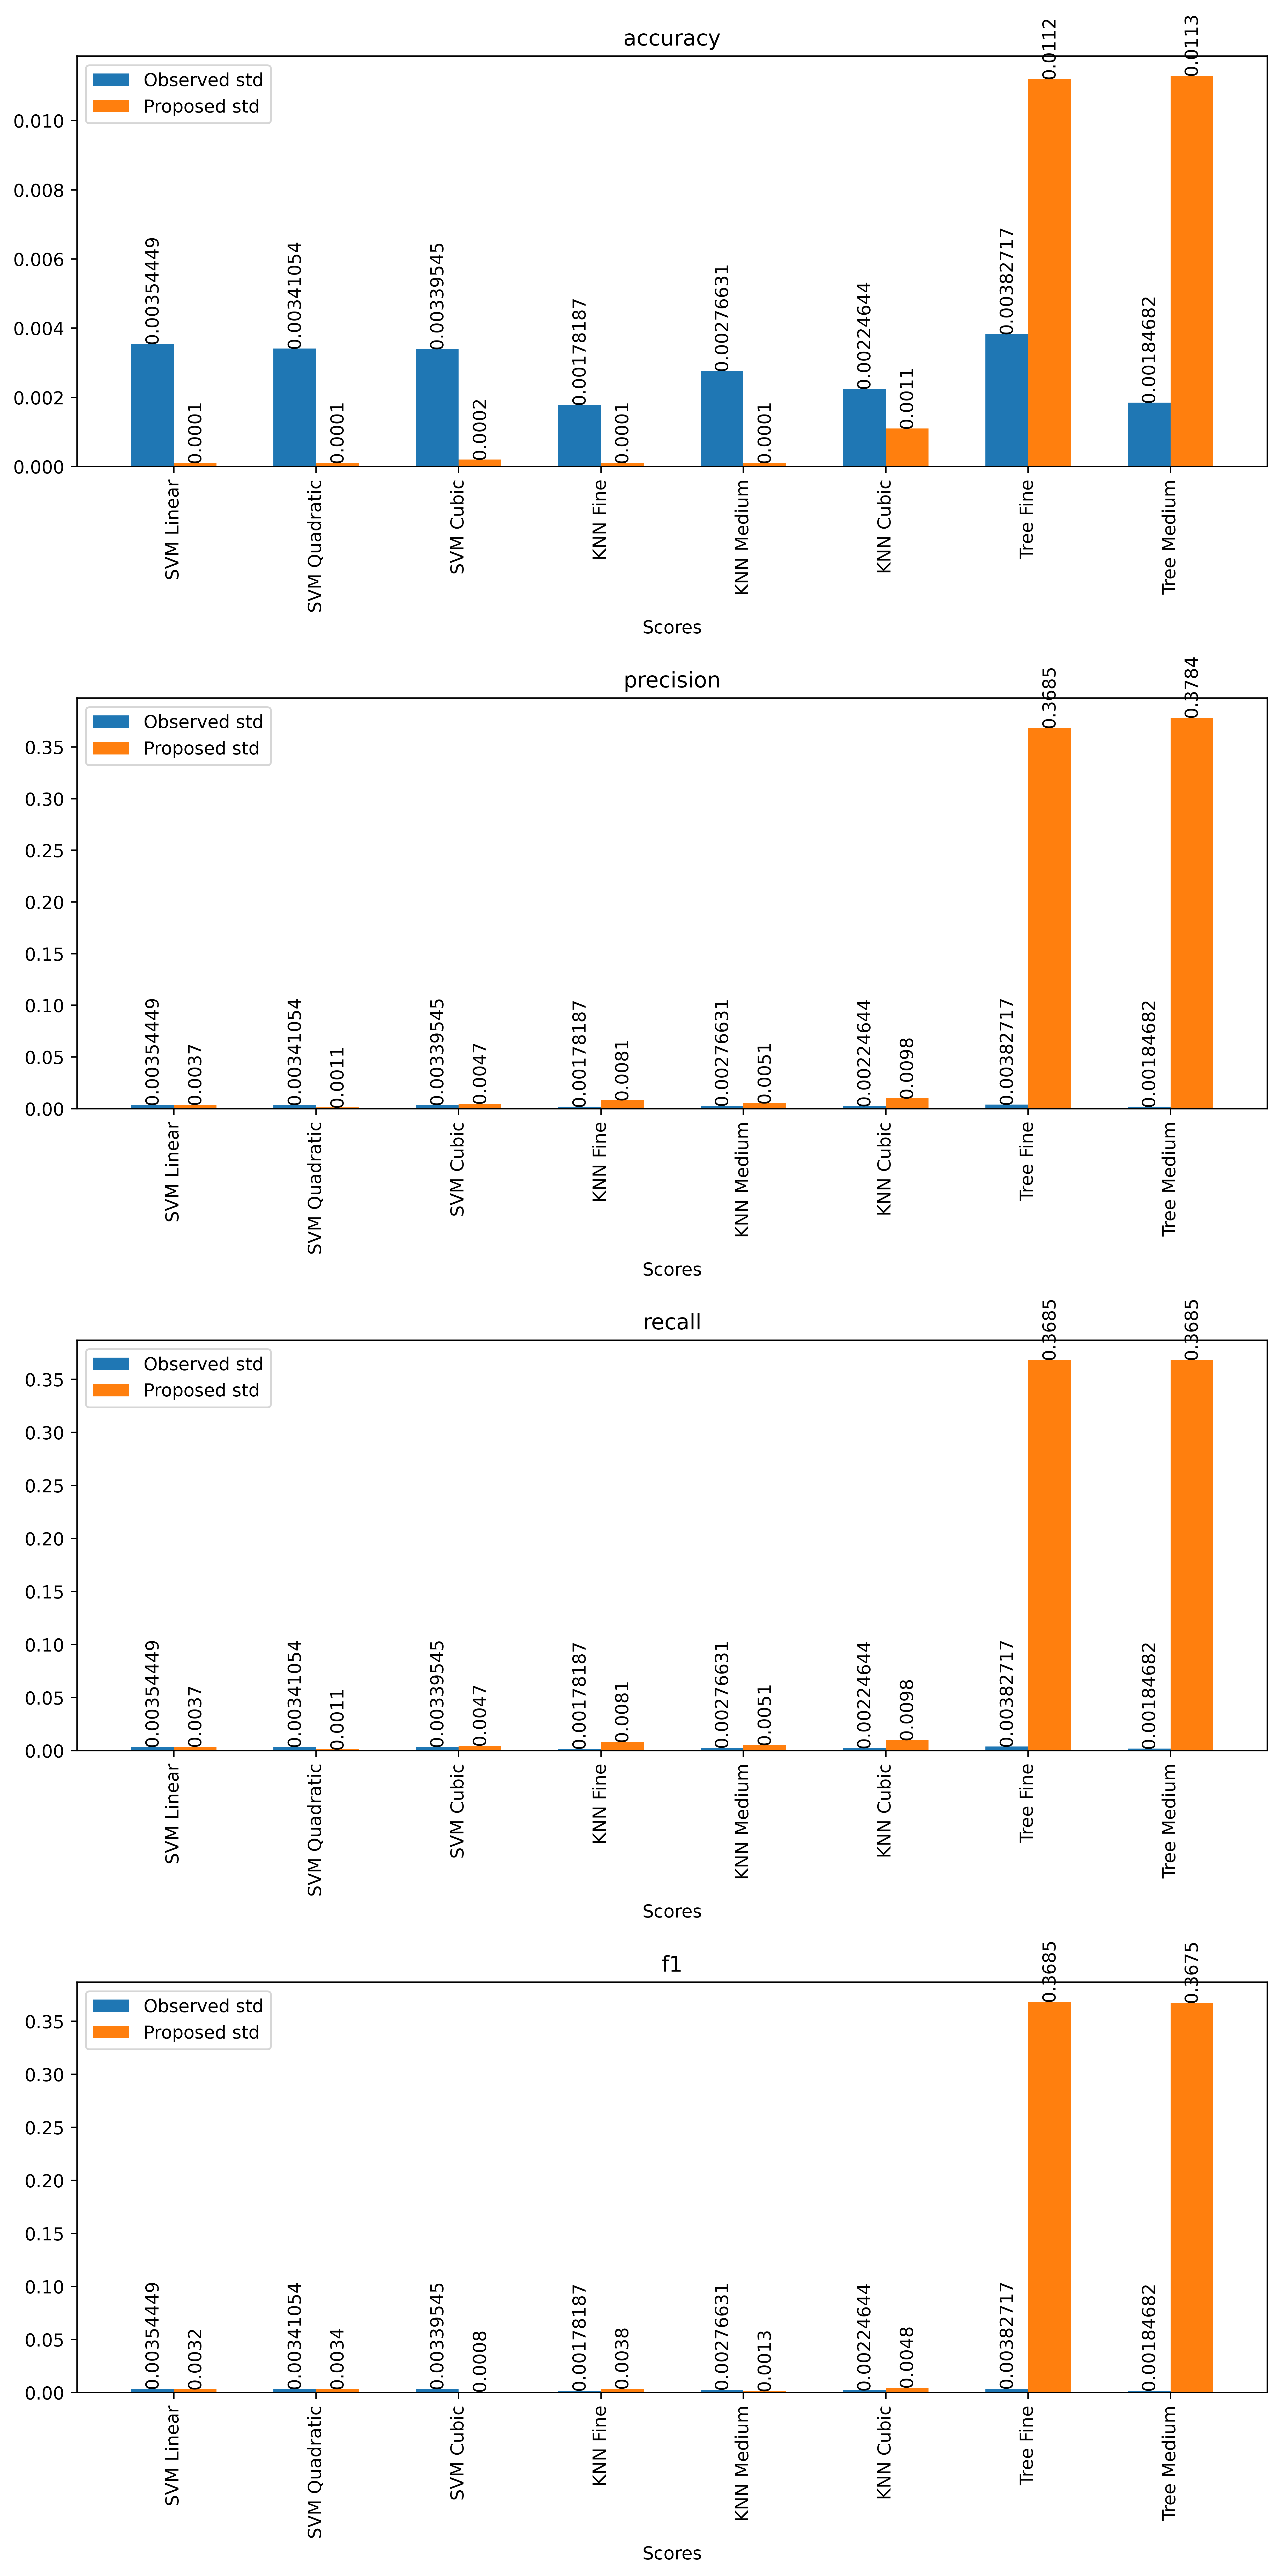

In [27]:
score_type = ['accuracy', 'precision', 'recall', 'f1']

labels = ['SVM Linear', 'SVM Quadratic', 'SVM Cubic', 'KNN Fine', 
          'KNN Medium', 'KNN Cubic', 'Tree Fine', 'Tree Medium']


x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

pos = np.linspace(-width/2, width/2, 2)

fig, ax = plt.subplots(4, 1, figsize=(10, 20), dpi=500)

for i in range(len(score_type)):

    my_best = result.xs('std', axis=0, level=1, drop_level=False)[score_type[i]]
    their_best = their_result.xs('std', axis=0, level=1, drop_level=False)[score_type[i]]

    rects1 = ax[i].bar(x + pos[0], my_best, width, label=f'Observed std')
    rects2 = ax[i].bar(x + pos[1], their_best, width, label='Proposed std')

    ax[i].bar_label(rects1, rotation = 90)
    ax[i].bar_label(rects2, rotation = 90)
    ax[i].legend()
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[i].set_xlabel('Scores')
    ax[i].set_title(score_type[i])
    ax[i].set_xticks(x, labels, rotation = 90)
    
    fig.tight_layout()

plt.show()

In [28]:
# result.to_csv('result.csv')

# Part 2: Design a ML solution

In [54]:
clf1 = svm.LinearSVC()
clf2 = KNeighborsClassifier(n_neighbors=1)
clf3 = DecisionTreeClassifier(max_leaf_nodes = 100)
clf4 = SGDClassifier()

voting_clf = VotingClassifier(
    estimators=[('svm_linear', clf1), ('knn_fine', clf2), ('tree_fine', clf3), ('sgd', clf4)],
    voting='hard'
)

cv = KFold(n_splits=10, shuffle=True)
result_voting = K_fold_times(voting_clf, X, y, cv = cv,times=100)

df_result_voting = post_process(result_voting)

Iteration:  100


In [55]:
ada_clf = AdaBoostClassifier(
    base_estimator=svm.LinearSVC(),
    n_estimators=50,
)

cv = KFold(n_splits=10, shuffle=True)
result_ada = K_fold_times(voting_clf, X, y, cv = cv,times=100)

df_result_ada = post_process(result_ada)

Iteration:  100


In [60]:
our_result = pd.concat([df_result_voting, df_result_ada], axis=0)

our_models = np.append([], [
    ['Voting']*3, 
    ['AdaBoost']*3
])

arr2 = ['best', 'mean', 'std'] * 2

tuples = list(zip(our_models, arr2))

index = pd.MultiIndex.from_tuples(tuples, names=['model', 'result'])

our_result.set_index(index, inplace=True)

our_result.to_latex('our_result.tex')

display(our_result)

/tmp/ipykernel_7860/614861027.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  our_result.to_latex('our_result.tex')


accuracy  precision    recall  geo mean        f1
model    result                                                   
Voting   best    0.995567   0.995567  0.995567  0.997228  0.995567
         mean    0.987880   0.987880  0.987880  0.992413  0.987880
         std     0.002269   0.002269  0.002269  0.001421  0.002269
AdaBoost best    0.965426   0.965426  0.965426  0.978305  0.965426
         mean    0.876065   0.876065  0.876065  0.921126  0.876065
         std     0.050445   0.050445  0.050445  0.032936  0.050445